# Clustering - Préparation des données pour les analyses

## Introduction

Ce notebook centralise le prétraitement et le clustering des données immobilières qui seront utilisés dans les notebooks suivants (régression et séries temporelles). L'objectif est d'éviter la duplication de code et d'assurer une cohérence dans les analyses.

## 1. Imports et configuration

In [33]:
# Jupyter magic
%matplotlib inline

# Standard library imports
import os
import re
import time
import math
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed

# Third-party imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit, prange
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Géospatial imports
import geopandas as gpd
from shapely.geometry import Point

# Configuration de l'affichage pandas
pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes
pd.set_option('display.width', 1000)       # Ajuste la largeur pour éviter les coupures
pd.set_option('display.colheader_justify', 'center')  # Centre les noms des colonnes

# Ignorer les warnings
warnings.filterwarnings('ignore')

## 2. Configuration des chemins d'accès

Décommentez le chemin correspondant à votre environnement ou ajoutez le vôtre.

In [34]:
# Définition des chemins d'accès aux données
# Décommentez le chemin correspondant à votre environnement

# folder_path_M = '/Users/maximehenon/Documents/GitHub/MAR25_BDS_Compagnon_Immo/'
# folder_path_Y = "C:/Users/charl/OneDrive/Documents/Yasmine/DATASCIENTEST/FEV25-BDS-COMPAGNON"
# folder_path_C = '../data/processed/Sales'
folder_path_L = '/Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/'
# folder_path_LW = 'C:/Users/User/Downloads/drive-download-20250508T155351Z-1-001'

# Utilisez cette variable pour définir votre chemin
folder_path = folder_path_L  # Remplacez par votre variable de chemin

# Chemins des fichiers
train_file = os.path.join(folder_path, 'train_clean.csv')
test_file = os.path.join(folder_path, 'test_clean.csv')
geo_file = os.path.join(folder_path, 'contours-codes-postaux.geojson')

## 3. Chargement des données

In [35]:
def load_data(file_path, chunksize=100000):
    """Charge les données à partir d'un fichier CSV avec gestion des encodages.
    
    Args:
        file_path (str): Chemin du fichier CSV
        chunksize (int): Taille des chunks pour le chargement
        
    Returns:
        DataFrame: Données chargées
    """
    encodings = ['utf-8', 'ISO-8859-1', 'latin1']
    
    for encoding in encodings:
        try:
            print(f"⏳ Tentative d'ouverture avec encodage : {encoding}")
            chunks = pd.read_csv(
                file_path,
                sep=";",
                chunksize=chunksize,
                index_col="date",
                parse_dates=["date"],
                on_bad_lines="skip",
                low_memory=False,
                encoding=encoding
            )
            # Process chunks
            data = pd.concat(chunk for chunk in chunks).sort_values(by="date")
            print(f"✅ Fichier lu avec succès avec encodage : {encoding}")
            return data
        except Exception as e:
            print(f"❌ Erreur avec encodage {encoding}: {e}")
    
    raise ValueError("Impossible de lire le fichier avec les encodages disponibles")

# Chargement des données d'entraînement
print("Chargement des données d'entraînement...")
train_cluster = load_data(train_file)

# Chargement des données de test
print("\nChargement des données de test...")
test_cluster = load_data(test_file)

# Ajout d'une colonne pour identifier l'origine (train/test)
train_cluster['split'] = 'train'
test_cluster['split'] = 'test'

# Combinaison des données pour le traitement
train_cluster = pd.concat([train_cluster, test_cluster])

print("\nShape du Dataset:", train_cluster.shape)
display(train_cluster.head())

Chargement des données d'entraînement...
⏳ Tentative d'ouverture avec encodage : utf-8
✅ Fichier lu avec succès avec encodage : utf-8

Chargement des données de test...
⏳ Tentative d'ouverture avec encodage : utf-8
✅ Fichier lu avec succès avec encodage : utf-8

Shape du Dataset: (5116413, 40)


,typedebien,typedetransaction,etage,surface,surface_terrain,nb_pieces,balcon,eau,bain,dpeL,dpeC,mapCoordonneesLatitude,mapCoordonneesLongitude,nb_etages,places_parking,cave,exposition,ges_class,annee_construction,nb_toilettes,porte_digicode,ascenseur,charges_copro,chauffage_energie,chauffage_systeme,chauffage_mode,logement_neuf,INSEE_COM,loyer_m2_median_n6,nb_log_n6,taux_rendement_n6,loyer_m2_median_n7,nb_log_n7,taux_rendement_n7,prix_m2_vente,avg_purchase_price_m2,avg_rent_price_m2,rental_yield_pct,IPS_primaire,split
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01,m,v,0,126,NaN,5,0,1,1,E,235.0,45.74510,-0.88170,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,n,17255,NaN,NaN,NaN,NaN,NaN,NaN,679.37,1782.0,9.336548,6.287238,96.40,train
2019-02-01,an,v,0,139,NaN,5,0,0,0,NaN,NaN,46.36815,6.15389,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,1143,21.44,4.0,0.036,20.9,26.0,0.035,7158.27,NaN,NaN,NaN,119.50,train
2019-02-01,an,v,0,82,NaN,4,0,0,0,NaN,NaN,48.74514,2.30348,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,92002,17.53,4.0,0.039,19.9,224.0,0.044,5402.44,5915.0,20.340683,4.126597,118.45,train
2019-02-01,a,v,4,68,NaN,3,0,0,2,D,218.0,48.91504,2.28202,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,n,92004,23.76,44.0,0.043,22.3,1219.0,0.041,6558.82,6831.0,22.823690,4.009432,109.60,train
2019-02-01,an,v,0,61,NaN,3,0,0,0,NaN,NaN,46.25845,6.11531,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,1160,20.00,121.0,0.045,20.1,298.0,0.046,5295.08,NaN,NaN,NaN,83.15,train


## 4. Enrichissement géospatial - Ajout des codes postaux

In [36]:
# Chargement des polygones de codes postaux
try:
    pcodes = gpd.read_file(geo_file)[['codePostal', 'geometry']]
    print("Polygones chargés :", pcodes.shape)
except Exception as e:
    print(f"Erreur lors du chargement du fichier géospatial: {e}")
    raise

# Préparation des données pour le traitement géospatial
train_cluster = train_cluster.reset_index(drop=False)  # Reset index pour éviter les problèmes de fusion
df_base = train_cluster.copy()
df_base = df_base.dropna(subset=['mapCoordonneesLatitude', 'mapCoordonneesLongitude'])
df_base['lat'] = df_base['mapCoordonneesLatitude']
df_base['lon'] = df_base['mapCoordonneesLongitude']
df_base['orig_index'] = df_base.index

# Fonction pour traiter un chunk de données
def process_chunk(chunk, pcodes):
    """Traite un chunk de données pour ajouter les codes postaux.
    
    Args:
        chunk (DataFrame): Chunk de données à traiter
        pcodes (GeoDataFrame): DataFrame contenant les polygones des codes postaux
        
    Returns:
        DataFrame: Résultat avec les codes postaux
    """
    chunk = chunk.copy()
    chunk['geometry'] = gpd.points_from_xy(chunk['lon'], chunk['lat'])
    gdf = gpd.GeoDataFrame(chunk, geometry='geometry', crs='EPSG:4326')
    joined = gpd.sjoin(gdf, pcodes, how='left', predicate='within')
    return joined[['orig_index', 'codePostal']]  # retour minimal

# Traitement par chunks pour limiter la consommation mémoire
chunksize = 100_000
results = []

for i in range(0, len(df_base), chunksize):
    chunk = df_base.iloc[i:i+chunksize]
    result = process_chunk(chunk, pcodes)
    results.append(result)

# Concaténation des résultats et fusion avec le DataFrame original
df_joined = pd.concat(results, ignore_index=True).drop_duplicates("orig_index")
train_cluster['orig_index'] = train_cluster.index  # pour merge
train_cluster = train_cluster.merge(df_joined[['orig_index', 'codePostal']], on="orig_index", how="left")
train_cluster.drop(columns=['orig_index'], inplace=True)

# Vérification du résultat
print(train_cluster[['mapCoordonneesLatitude', 'mapCoordonneesLongitude', 'codePostal', 'date']].head())
print("Code postal manquant :", train_cluster['codePostal'].isna().sum())

Polygones chargés : (6158, 2)
   mapCoordonneesLatitude  mapCoordonneesLongitude codePostal    date   
0         45.74510                -0.88170            17250   2019-02-01
1         46.36815                 6.15389            01220   2019-02-01
2         48.74514                 2.30348            92160   2019-02-01
3         48.91504                 2.28202            92600   2019-02-01
4         46.25845                 6.11531            01210   2019-02-01
Code postal manquant : 98277


## 5. Préparation des données pour l'analyse

Cette section prépare les données en définissant la date comme index et en ajoutant des variables temporelles.

In [37]:
# Définir la colonne 'date' comme index
train_cluster = train_cluster.set_index('date')

# Création des variables année et mois
train_cluster["Year"] = train_cluster.index.year
train_cluster["Month"] = train_cluster.index.month

# Traitement du code postal
train_cluster["codePostal"] = train_cluster["codePostal"].astype(str).str.replace(r"\.0$", "", regex=True)

# Correction des codes postaux de longueur insuffisante
def format_code_postal(code):
    if pd.isna(code):
        return code
    code = str(code)
    if len(code) < 5:
        return code.zfill(5)
    return code

train_cluster["codePostal"] = train_cluster["codePostal"].apply(format_code_postal)

# Affichage des données préparées
display(train_cluster.head())

,typedebien,typedetransaction,etage,surface,surface_terrain,nb_pieces,balcon,eau,bain,dpeL,dpeC,mapCoordonneesLatitude,mapCoordonneesLongitude,nb_etages,places_parking,cave,exposition,ges_class,annee_construction,nb_toilettes,porte_digicode,ascenseur,charges_copro,chauffage_energie,chauffage_systeme,chauffage_mode,logement_neuf,INSEE_COM,loyer_m2_median_n6,nb_log_n6,taux_rendement_n6,loyer_m2_median_n7,nb_log_n7,taux_rendement_n7,prix_m2_vente,avg_purchase_price_m2,avg_rent_price_m2,rental_yield_pct,IPS_primaire,split,codePostal,Year,Month
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01,m,v,0,126,NaN,5,0,1,1,E,235.0,45.74510,-0.88170,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,n,17255,NaN,NaN,NaN,NaN,NaN,NaN,679.37,1782.0,9.336548,6.287238,96.40,train,17250,2019,2
2019-02-01,an,v,0,139,NaN,5,0,0,0,NaN,NaN,46.36815,6.15389,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,1143,21.44,4.0,0.036,20.9,26.0,0.035,7158.27,NaN,NaN,NaN,119.50,train,01220,2019,2
2019-02-01,an,v,0,82,NaN,4,0,0,0,NaN,NaN,48.74514,2.30348,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,92002,17.53,4.0,0.039,19.9,224.0,0.044,5402.44,5915.0,20.340683,4.126597,118.45,train,92160,2019,2
2019-02-01,a,v,4,68,NaN,3,0,0,2,D,218.0,48.91504,2.28202,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,n,92004,23.76,44.0,0.043,22.3,1219.0,0.041,6558.82,6831.0,22.823690,4.009432,109.60,train,92600,2019,2
2019-02-01,an,v,0,61,NaN,3,0,0,0,NaN,NaN,46.25845,6.11531,NaN,NaN,True,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,o,1160,20.00,121.0,0.045,20.1,298.0,0.046,5295.08,NaN,NaN,NaN,83.15,train,01210,2019,2


## 6. Création de la variable hybride 'Zone Mixte'

### Constat initial

Nous avons constaté que de nombreux codes postaux disposent de très peu de données, parfois moins de 10 ventes. Cela pose plusieurs problèmes :
- Les statistiques calculées (moyenne, écart-type, TCAM) sont peu fiables.
- Ces points faiblement renseignés peuvent brouiller le clustering global.

### Solution mise en œuvre : agrégation hybride

Pour conserver à la fois la précision locale quand elle est disponible, et la stabilité statistique ailleurs, nous adoptons une stratégie hybride :

- Si un code postal contient au moins 10 observations, il est conservé tel quel.
- Sinon, il est regroupé au niveau du département (les 2 premiers chiffres du code postal).

Cette approche permet de :
- Préserver la finesse géographique dans les zones bien renseignées
- Limiter le bruit dans les zones sous-représentées
- Améliorer la qualité du clustering sans perdre d'information utile

In [38]:
# Réinitialisation de l'index pour faciliter les manipulations
train_cluster_clean = train_cluster.reset_index()

# Ajout de la colonne département
train_cluster_clean["departement"] = train_cluster_clean["codePostal"].astype(str).str[:2]

# Identification des codes postaux fréquents (au moins 10 observations)
cp_counts = train_cluster_clean["codePostal"].value_counts()
cp_frequents_str = set(cp_counts[cp_counts >= 10].index)

# Fonction pour créer la zone mixte
def regroup_code(row, frequents_set):
    """Crée une zone mixte basée sur le code postal ou le département.
    
    Args:
        row (Series): Ligne du DataFrame
        frequents_set (set): Ensemble des codes postaux fréquents
        
    Returns:
        str: Code postal ou code département selon la fréquence
    """
    cp = row["codePostal"]
    if pd.isna(cp):
        return "inconnu"
    
    cp = str(cp)
    if cp in frequents_set:
        return cp  # code postal détaillé
    elif cp.startswith("97") and len(cp) >= 3:
        return cp[:3]  # DROM-COM
    elif cp.isdigit() and len(cp) == 5:
        return cp[:2]  # département
    else:
        return "inconnu"

# Application de la fonction pour créer la zone mixte
train_cluster_clean["zone_mixte"] = train_cluster_clean.apply(
    lambda row: regroup_code(row, cp_frequents_str), axis=1
)

# Affichage des résultats
print("Nombre de zones mixtes créées :", train_cluster_clean["zone_mixte"].nunique())
print("\nExemples de zones mixtes :")
display(train_cluster_clean[["codePostal", "departement", "zone_mixte"]].sample(10))

Nombre de zones mixtes créées : 5941

Exemples de zones mixtes :


,codePostal,departement,zone_mixte
2839665,69130,69,69130
2482550,33130,33,33130
1999161,74130,74,74130
413913,01560,01,01560
3716918,34000,34,34000
1012473,45510,45,45510
94924,68480,68,68480
773736,25000,25,25000
4702836,78500,78,78500
4386746,94500,94,94500


## 7. Agrégation des données par mois et zone mixte

In [39]:
# Agrégation mensuelle par zone mixte
train_mensuel = (
    train_cluster_clean.groupby(["Year", "Month", "zone_mixte"])
    .agg(
        prix_m2_mean=("prix_m2_vente", "mean"),
        volume_ventes=("prix_m2_vente", "count")
    )
    .reset_index()
)

# Reconstruction du code postal pour les analyses
def get_code_postal_final(zone):
    """Reconstruit un code postal à partir d'une zone mixte.
    
    Args:
        zone (str): Zone mixte (code postal ou département)
        
    Returns:
        str: Code postal reconstruit
    """
    s = str(zone)
    if s.isdigit() and len(s) == 5:
        return s
    if s.isdigit() and len(s) == 2:
        return s + "000"
    if s.startswith("97") and len(s) == 3:
        return s + "00"
    return "inconnu"

train_mensuel["codePostal_recons"] = train_mensuel["zone_mixte"].apply(get_code_postal_final)

# Création de la date complète
train_mensuel["date"] = pd.to_datetime(
    train_mensuel["Year"].astype(str) + "-" + 
    train_mensuel["Month"].astype(str).str.zfill(2) + "-01"
)

# Affichage des résultats
print("Données mensuelles agrégées :")
display(train_mensuel.head())

Données mensuelles agrégées :


,Year,Month,zone_mixte,prix_m2_mean,volume_ventes,codePostal_recons,date
0,2019,2,00nan,3667.700533,169,inconnu,2019-02-01
1,2019,2,01000,1854.286667,12,01000,2019-02-01
2,2019,2,01090,2568.180000,2,01090,2019-02-01
3,2019,2,01120,2808.736000,10,01120,2019-02-01
4,2019,2,01130,2562.030000,4,01130,2019-02-01


## 8. Création des variables pour le clustering

### 8.1 Calcul du taux de croissance annuel lissé (TCAM)

L'objectif est de prendre en compte la tendance globale de l'évolution des prix par code postal,
sur toute la période observée, en lissant les variations mois par mois.

In [40]:
# Création de variables temporelles pour l'analyse
train_mensuel["ym_ordinal"] = train_mensuel["Year"] * 12 + train_mensuel["Month"]
train_mensuel = train_mensuel.sort_values(["codePostal_recons", "date"])
train_mensuel["t"] = (
    train_mensuel
    .groupby("codePostal_recons")["ym_ordinal"]
    .transform(lambda x: x - x.min())
)

# Calcul des lags et moyennes mobiles
train_mensuel["prix_lag_1m"] = (
    train_mensuel
    .groupby("codePostal_recons")["prix_m2_mean"]
    .shift(1)
)
train_mensuel["prix_roll_3m"] = (
    train_mensuel
    .groupby("codePostal_recons")["prix_m2_mean"]
    .rolling(3, closed="left")
    .mean()
    .reset_index(level=0, drop=True)
)

# Calcul du logarithme des prix pour le TCAM
train_mensuel["log_prix"] = np.log(train_mensuel["prix_m2_mean"])

# Fonction pour calculer le TCAM par régression linéaire
def compute_tcam(df):
    """Calcule le taux de croissance annuel moyen par régression linéaire.
    
    Args:
        df (DataFrame): DataFrame contenant les colonnes t et log_prix
        
    Returns:
        float: TCAM en pourcentage annualisé
    """
    if len(df) < 2 or df["log_prix"].isna().any():
        return np.nan
    X = df[["t"]].values.reshape(-1, 1)
    y = df["log_prix"].values
    coef = LinearRegression().fit(X, y).coef_[0]
    return (np.exp(coef) - 1) * 100 * 12  # Annualisation

# Calcul du TCAM par code postal
tcam_df = (
    train_mensuel
    .groupby("codePostal_recons")
    .apply(compute_tcam)
    .reset_index(name="tc_am_reg")
)

# Fusion du TCAM avec les données mensuelles
train_mensuel = (
    train_mensuel
    .merge(tcam_df, on="codePostal_recons", how="left")
    # Ne drop que les lignes où les features indispensables sont manquantes
    .dropna(subset=["prix_lag_1m", "prix_roll_3m", "tc_am_reg"])
    .reset_index(drop=True)
)

# Affichage des résultats
print("Données avec TCAM calculé :")
display(train_mensuel.head())

Données avec TCAM calculé :


,Year,Month,zone_mixte,prix_m2_mean,volume_ventes,codePostal_recons,date,ym_ordinal,t,prix_lag_1m,prix_roll_3m,log_prix,tc_am_reg
0,2019,5,01000,1758.800000,20,01000,2019-05-01,24233,3,2389.175714,2104.053016,7.472387,3.411165
1,2019,6,01000,2505.538750,16,01000,2019-06-01,24234,4,1758.800000,2072.224127,7.826259,3.411165
2,2019,7,01000,2286.804000,10,01000,2019-07-01,24235,5,2505.538750,2217.838155,7.734910,3.411165
3,2019,8,01000,1464.691111,18,01000,2019-08-01,24236,6,2286.804000,2183.714250,7.289400,3.411165
4,2019,9,01000,2407.410000,8,01000,2019-09-01,24237,7,1464.691111,2085.677954,7.786307,3.411165


## 8.2 Calcul des autres features pour le clustering

In [41]:
# Création du DataFrame pour le clustering
df_cluster_input = (
    train_mensuel
    .groupby("codePostal_recons")
    .agg(
        # Statistiques sur les prix
        prix_m2_mean=("prix_m2_mean", "mean"),
        prix_m2_std=("prix_m2_mean", "std"),
        prix_m2_max=("prix_m2_mean", "max"),
        prix_m2_min=("prix_m2_mean", "min"),
        # Statistiques sur les lags et rolling
        avg_lag_1m=("prix_lag_1m", "mean"),
        avg_roll_3m=("prix_roll_3m", "mean"),
    )
    .assign(
        # Coefficient de variation (mesure de dispersion relative)
        prix_m2_cv=lambda df: df["prix_m2_std"] / df["prix_m2_mean"]
    )
    .reset_index()
    # Fusion avec le TCAM déjà calculé
    .merge(tcam_df, on="codePostal_recons", how="left")
)

# Affichage des features pour le clustering
print("Features pour le clustering :")
display(df_cluster_input.head())

Features pour le clustering :


,codePostal_recons,prix_m2_mean,prix_m2_std,prix_m2_max,prix_m2_min,avg_lag_1m,avg_roll_3m,prix_m2_cv,tc_am_reg
0,01000,2246.608898,252.165346,2710.617027,1247.125,2246.728258,2241.499334,0.112243,3.411165
1,01090,2813.620113,380.249291,4204.983333,2091.760,2797.056145,2794.773084,0.135146,2.329043
2,01100,1737.121565,257.445026,2796.891111,1200.000,1735.153623,1728.114280,0.148202,3.623537
3,01110,1498.283436,497.361494,2577.750000,745.770,1500.007365,1494.329577,0.331954,7.739366
4,01120,3159.539530,424.299980,4168.442000,1789.015,3138.108566,3128.430538,0.134292,5.615145


## 9. Visualisation des distributions des features

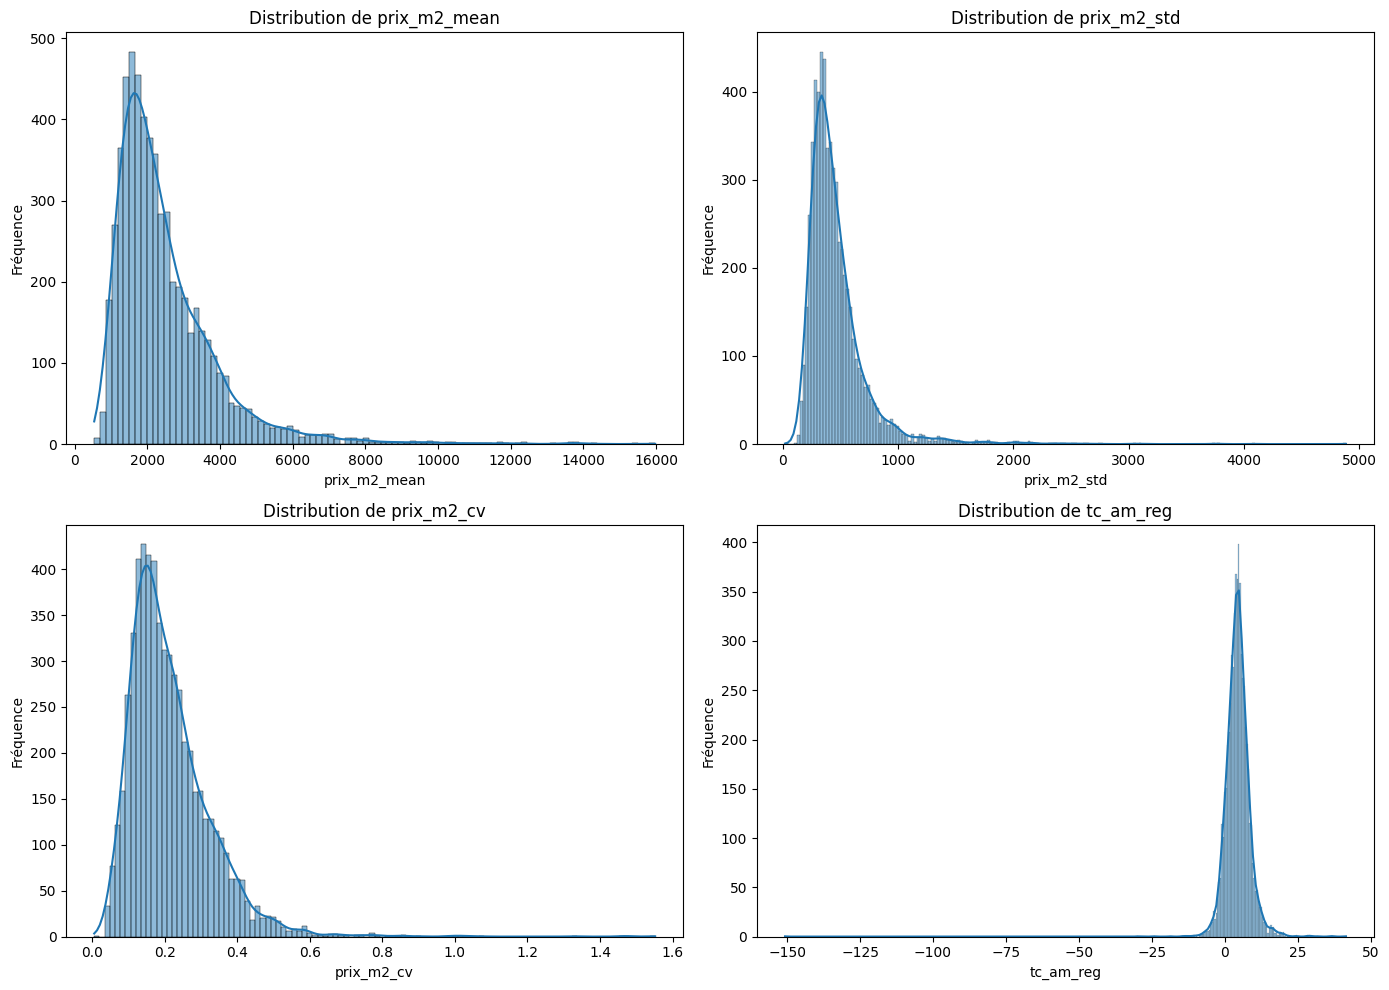

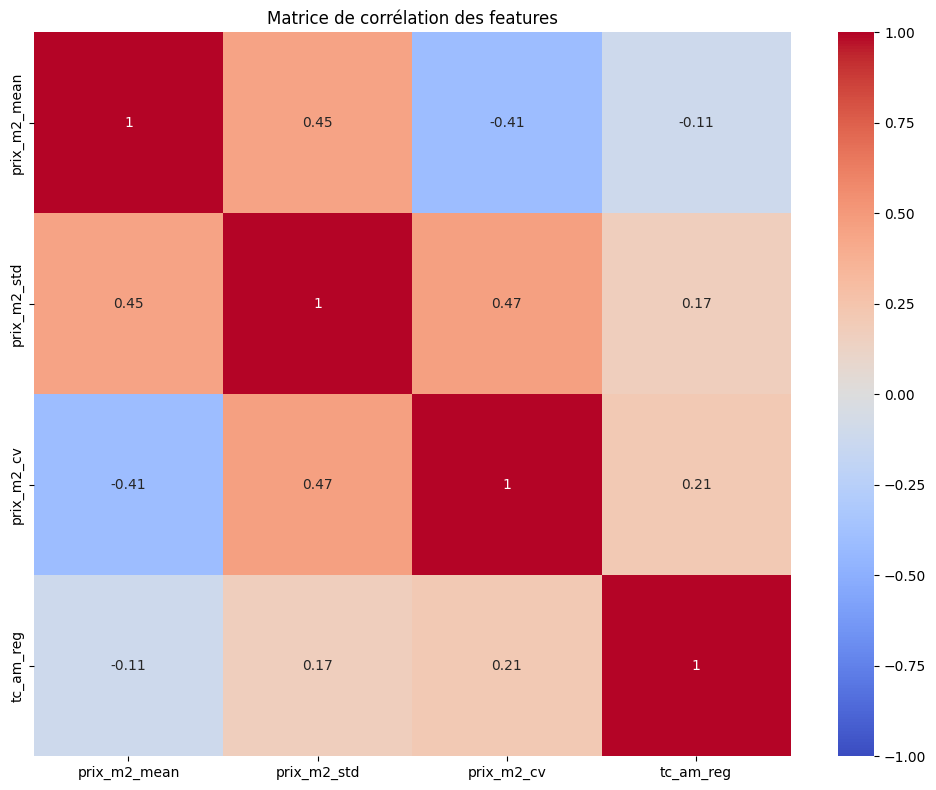

In [42]:
# Sélection des features numériques pour le clustering
features_for_clustering = [
    "prix_m2_mean", "prix_m2_std", "prix_m2_cv", "tc_am_reg"
]

# Visualisation des distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features_for_clustering):
    sns.histplot(df_cluster_input[feature].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution de {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Fréquence")

plt.tight_layout()
plt.show()

# Matrice de corrélation
plt.figure(figsize=(10, 8))
corr_matrix = df_cluster_input[features_for_clustering].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice de corrélation des features")
plt.tight_layout()
plt.show()

## 10. Clustering KMeans

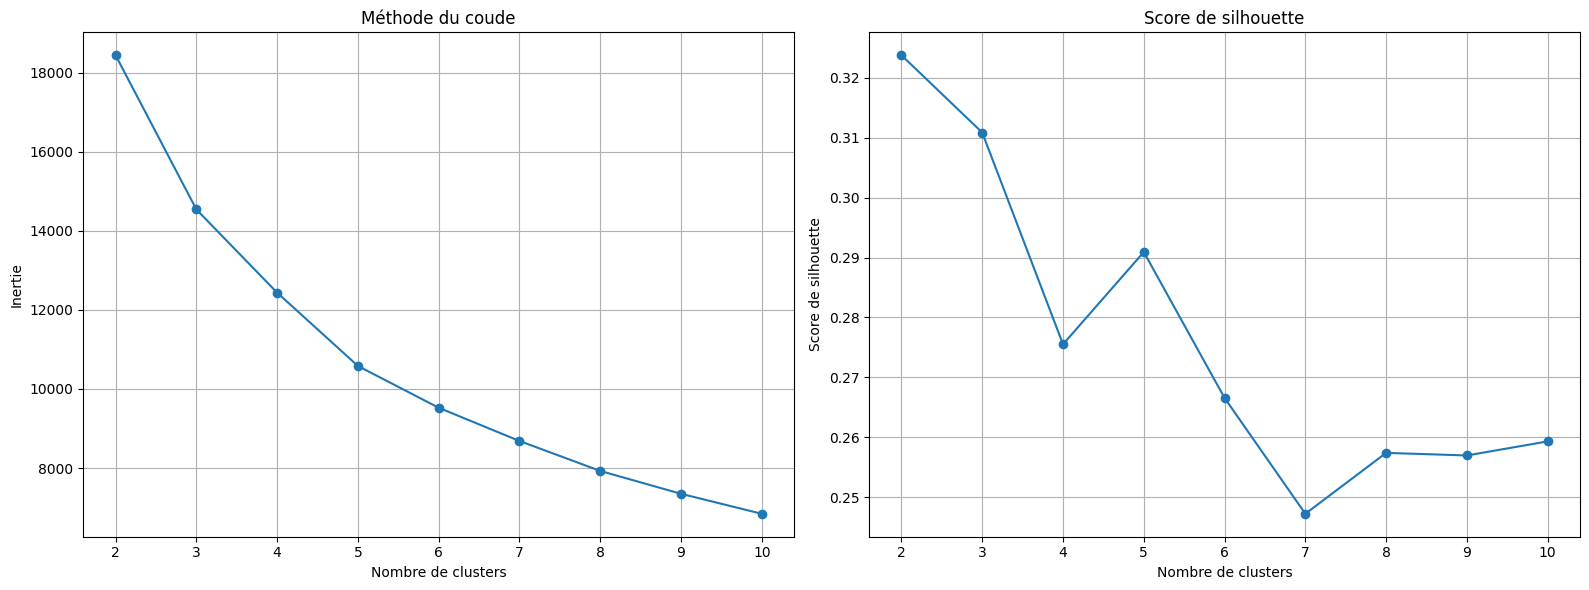

Clustering effectué avec 4 clusters

Répartition des clusters :
cluster
1    3166
3    1326
2    1257
0     152
Name: count, dtype: int64

Caractéristiques moyennes des clusters :


,prix_m2_mean,prix_m2_std,prix_m2_cv,tc_am_reg
cluster,,,,
0,5702.384299,1664.441830,0.348006,6.604709
1,1924.024554,350.462202,0.192771,3.650836
2,4269.813251,511.882767,0.125325,2.606554
3,1796.631711,569.692280,0.336310,8.035278


In [43]:
# Préparation des données pour le clustering
df_for_clustering = df_cluster_input.dropna(subset=features_for_clustering).copy()

# Standardisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_for_clustering[features_for_clustering])

# Détermination du nombre optimal de clusters avec la méthode du coude
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualisation de la méthode du coude
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphique de l'inertie
ax1.plot(k_range, inertia, 'o-')
ax1.set_xlabel('Nombre de clusters')
ax1.set_ylabel('Inertie')
ax1.set_title('Méthode du coude')
ax1.grid(True)

# Graphique du score de silhouette
ax2.plot(k_range, silhouette_scores, 'o-')
ax2.set_xlabel('Nombre de clusters')
ax2.set_ylabel('Score de silhouette')
ax2.set_title('Score de silhouette')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Choix du nombre optimal de clusters
optimal_k = 4  # À ajuster en fonction des résultats

# Application du clustering avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_for_clustering['cluster'] = kmeans.fit_predict(X_scaled)

# Affichage des résultats
print(f"Clustering effectué avec {optimal_k} clusters")
print("\nRépartition des clusters :")
print(df_for_clustering['cluster'].value_counts())

# Caractéristiques des clusters
cluster_stats = df_for_clustering.groupby('cluster')[features_for_clustering].mean()
print("\nCaractéristiques moyennes des clusters :")
display(cluster_stats)

## 11. Visualisation des clusters

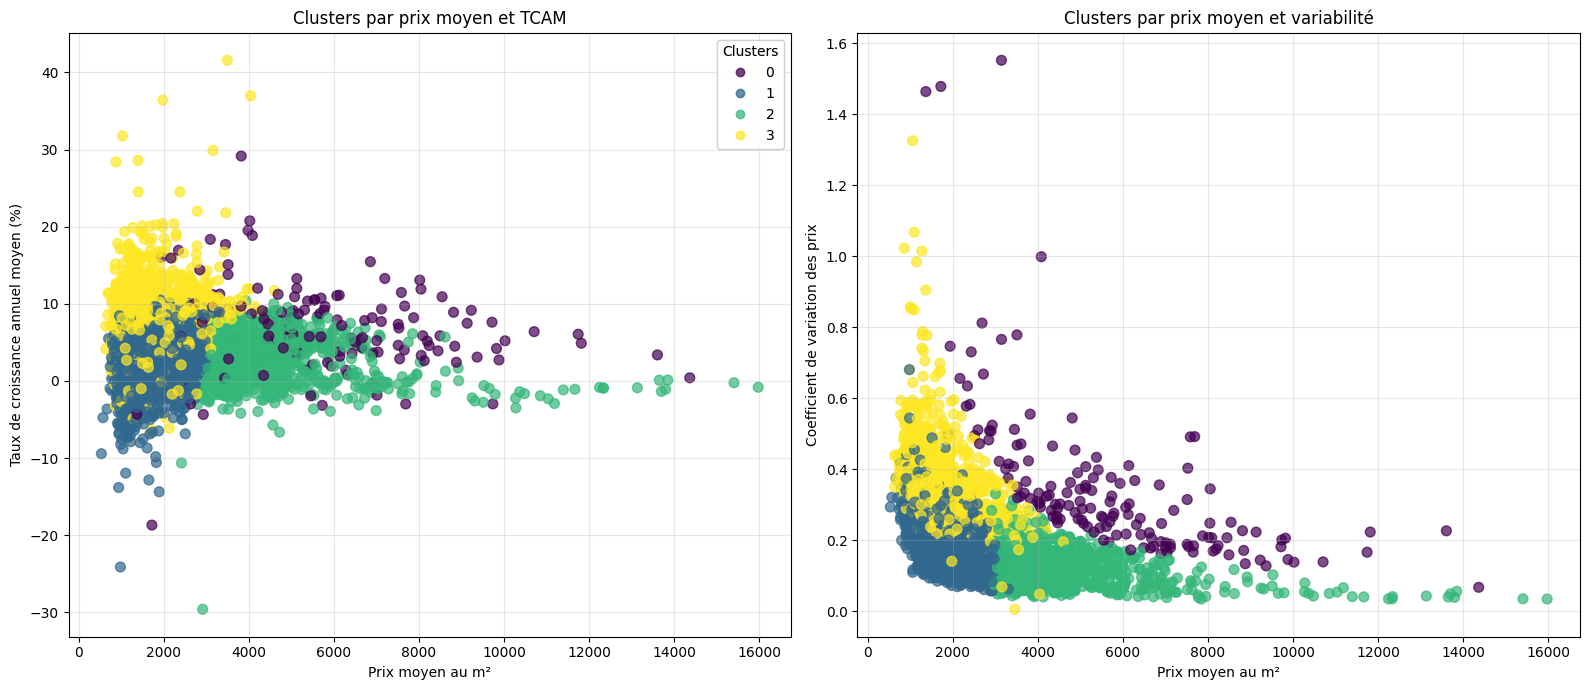

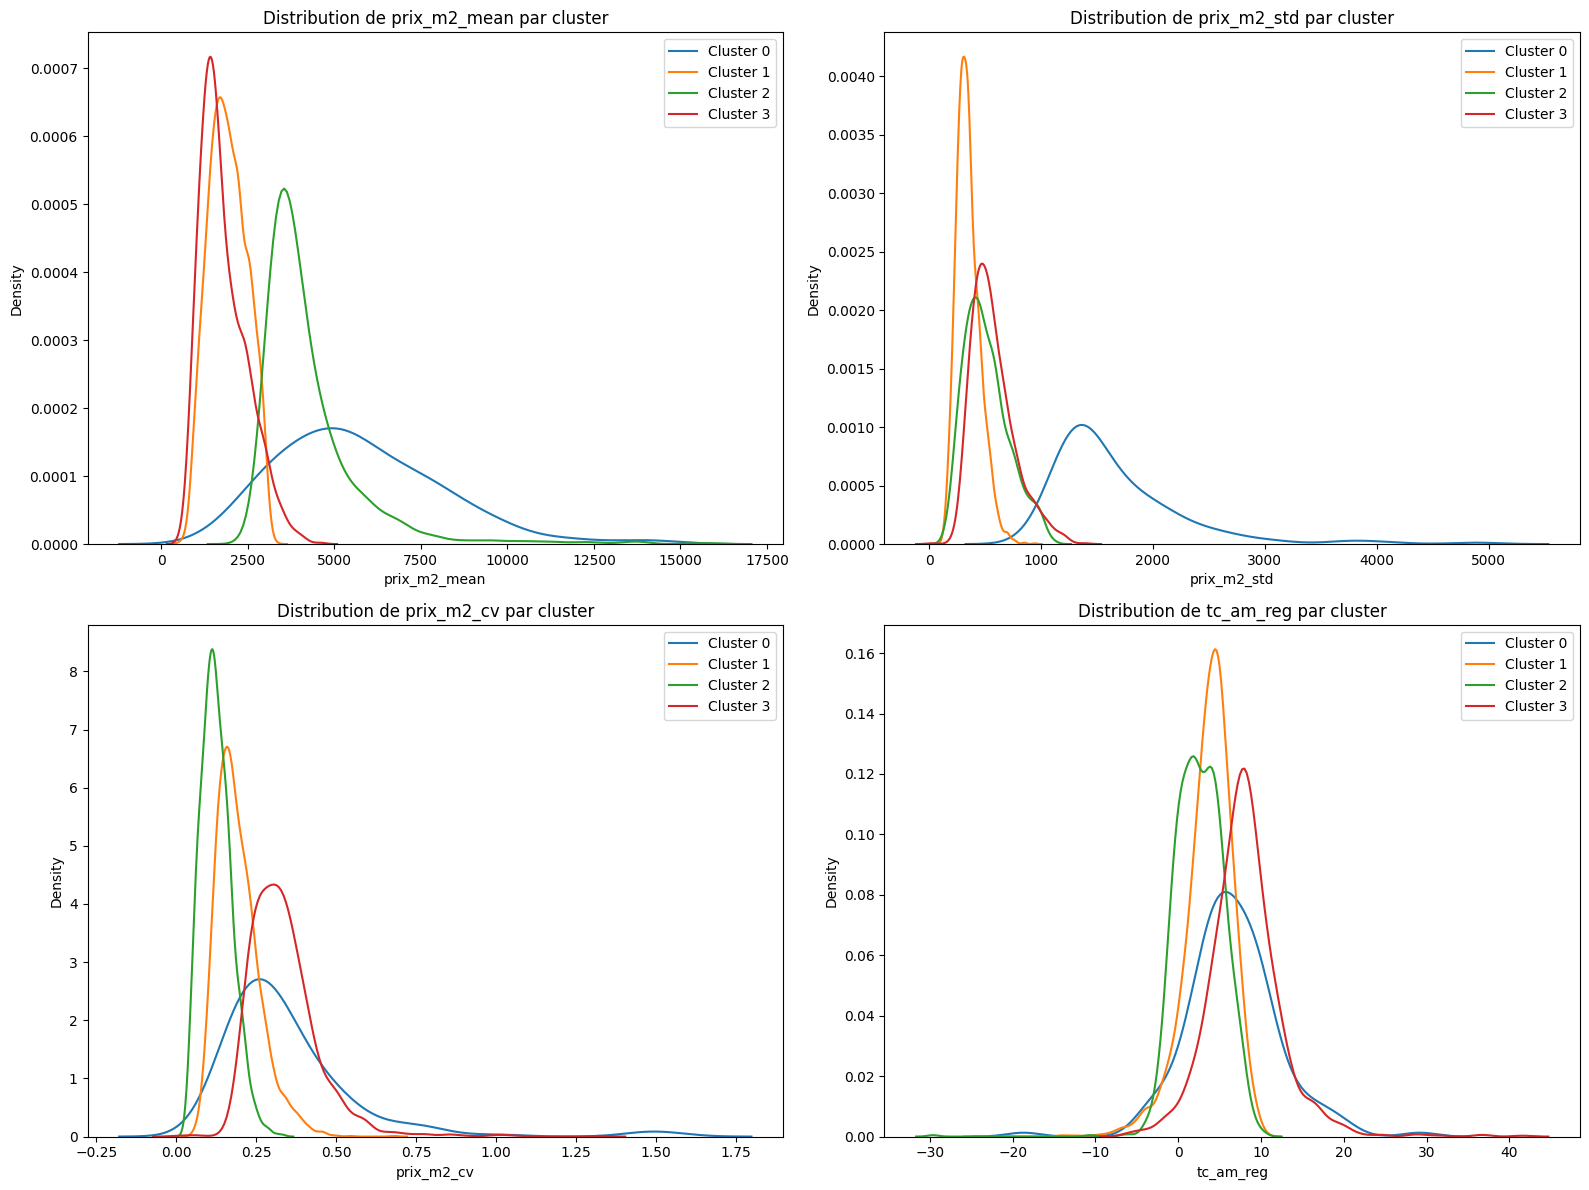

In [44]:
# Visualisation des clusters en fonction des features principales
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Graphique 1: Prix moyen vs TCAM
scatter1 = axes[0].scatter(
    df_for_clustering['prix_m2_mean'],
    df_for_clustering['tc_am_reg'],
    c=df_for_clustering['cluster'],
    cmap='viridis',
    alpha=0.7,
    s=50
)
axes[0].set_xlabel('Prix moyen au m²')
axes[0].set_ylabel('Taux de croissance annuel moyen (%)')
axes[0].set_title('Clusters par prix moyen et TCAM')
axes[0].grid(True, alpha=0.3)

# Graphique 2: Coefficient de variation vs Prix moyen
scatter2 = axes[1].scatter(
    df_for_clustering['prix_m2_mean'],
    df_for_clustering['prix_m2_cv'],
    c=df_for_clustering['cluster'],
    cmap='viridis',
    alpha=0.7,
    s=50
)
axes[1].set_xlabel('Prix moyen au m²')
axes[1].set_ylabel('Coefficient de variation des prix')
axes[1].set_title('Clusters par prix moyen et variabilité')
axes[1].grid(True, alpha=0.3)

# Légende commune
legend1 = axes[0].legend(*scatter1.legend_elements(), title="Clusters")
axes[0].add_artist(legend1)

plt.tight_layout()
plt.show()

# Visualisation des distributions par cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(features_for_clustering):
    for cluster in range(optimal_k):
        sns.kdeplot(
            df_for_clustering[df_for_clustering['cluster'] == cluster][feature],
            ax=axes[i],
            label=f'Cluster {cluster}'
        )
    axes[i].set_title(f'Distribution de {feature} par cluster')
    axes[i].set_xlabel(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

## 12. Interprétation des clusters

Analysons les caractéristiques de chaque cluster pour leur donner une interprétation métier.

In [45]:
# Interprétation des clusters
cluster_names = {
    0: "Marché stable et abordable",
    1: "Marché premium en croissance",
    2: "Marché volatil en transition",
    3: "Marché économique en déclin"
}

# Ajustez les noms en fonction des caractéristiques réelles de vos clusters
# Ces noms sont des exemples et doivent être adaptés à vos résultats

# Création d'un DataFrame avec les caractéristiques et les noms des clusters
cluster_profiles = cluster_stats.copy()
cluster_profiles['nom_cluster'] = cluster_profiles.index.map(cluster_names)
cluster_profiles = cluster_profiles.reset_index()

# Affichage des profils de clusters
print("Profils des clusters :")
display(cluster_profiles)

# Exemples de zones dans chaque cluster
print("\nExemples de zones par cluster :")
for cluster in range(optimal_k):
    examples = df_for_clustering[df_for_clustering['cluster'] == cluster]['codePostal_recons'].sample(min(5, sum(df_for_clustering['cluster'] == cluster))).tolist()
    print(f"Cluster {cluster} ({cluster_names[cluster]}): {examples}")

Profils des clusters :


,cluster,prix_m2_mean,prix_m2_std,prix_m2_cv,tc_am_reg,nom_cluster
0,0,5702.384299,1664.441830,0.348006,6.604709,Marché stable et abordable
1,1,1924.024554,350.462202,0.192771,3.650836,Marché premium en croissance
2,2,4269.813251,511.882767,0.125325,2.606554,Marché volatil en transition
3,3,1796.631711,569.692280,0.336310,8.035278,Marché économique en déclin



Exemples de zones par cluster :
Cluster 0 (Marché stable et abordable): ['38114', '56780', '73590', '17630', '20113']
Cluster 1 (Marché premium en croissance): ['72380', '58600', '33480', '82210', '34480']
Cluster 2 (Marché volatil en transition): ['06620', '20110', '73290', '77280', '97354']
Cluster 3 (Marché économique en déclin): ['18380', '43390', '79290', '88640', '23120']


## 13. Fusion des clusters avec les données originales

In [46]:
# Création d'un dictionnaire de mapping code postal -> cluster
cp_to_cluster = dict(zip(df_for_clustering['codePostal_recons'], df_for_clustering['cluster']))

# Fonction pour attribuer un cluster à chaque code postal
def assign_cluster(cp):
    """Attribue un cluster à un code postal.
    
    Args:
        cp (str): Code postal
        
    Returns:
        int: Numéro de cluster ou -1 si non trouvé
    """
    if pd.isna(cp):
        return -1
    
    cp = str(cp)
    # Essai direct avec le code postal
    if cp in cp_to_cluster:
        return cp_to_cluster[cp]
    
    # Essai avec le code postal reconstruit (pour les départements)
    if len(cp) >= 2:
        dept_code = cp[:2] + "000"
        if dept_code in cp_to_cluster:
            return cp_to_cluster[dept_code]
    
    # Pour les DROM-COM
    if cp.startswith("97") and len(cp) >= 3:
        drom_code = cp[:3] + "00"
        if drom_code in cp_to_cluster:
            return cp_to_cluster[drom_code]
    
    return -1  # Cluster inconnu

# Application du clustering aux données originales
train_cluster_clean['cluster'] = train_cluster_clean['codePostal'].apply(assign_cluster)

# Ajout des noms de clusters
train_cluster_clean['nom_cluster'] = train_cluster_clean['cluster'].map(lambda x: cluster_names.get(x, "Non classé"))

# Vérification de la répartition
print("Répartition des clusters dans les données originales :")
print(train_cluster_clean['cluster'].value_counts(dropna=False))

# Affichage d'un échantillon
print("\nÉchantillon des données avec clusters :")
display(train_cluster_clean[['codePostal', 'departement', 'zone_mixte', 'cluster', 'nom_cluster', 'prix_m2_vente']].sample(10))

Répartition des clusters dans les données originales :
cluster
 1    2378959
 2    2256255
 3     293705
-1      98277
 0      89217
Name: count, dtype: int64

Échantillon des données avec clusters :


,codePostal,departement,zone_mixte,cluster,nom_cluster,prix_m2_vente
2238254,33390,33,33390,1,Marché premium en croissance,2195.94
768819,04100,04,04100,1,Marché premium en croissance,1833.33
822001,71200,71,71200,1,Marché premium en croissance,584.75
4234774,44270,44,44270,1,Marché premium en croissance,1833.33
2952738,44000,44,44000,2,Marché volatil en transition,3094.10
2718077,30130,30,30130,1,Marché premium en croissance,1776.47
1677314,66410,66,66410,0,Marché stable et abordable,1788.73
4502209,01800,01,01800,2,Marché volatil en transition,3246.15
1941459,33185,33,33185,2,Marché volatil en transition,3930.23
3961014,33120,33,33120,2,Marché volatil en transition,6525.00


## 14. Agrégation mensuelle pour l'analyse de séries temporelles

In [47]:
# Agrégation mensuelle par département et code postal
train_mensuel_final = (
    train_cluster_clean.groupby(["Year", "Month", "departement", "codePostal", "cluster", "nom_cluster", "split"])
    .agg(
        prix_m2_vente=("prix_m2_vente", "mean"),
        nb_transactions=("prix_m2_vente", "count")
    )
    .reset_index()
)

# Création de la date complète
train_mensuel_final["date"] = pd.to_datetime(
    train_mensuel_final["Year"].astype(str) + "-" + 
    train_mensuel_final["Month"].astype(str).str.zfill(2) + "-01"
)

# Affichage des résultats
print("Données mensuelles finales :")
display(train_mensuel_final.head())

Données mensuelles finales :


,Year,Month,departement,codePostal,cluster,nom_cluster,split,prix_m2_vente,nb_transactions,date
0,2019,2,00,00nan,-1,Non classé,test,3591.987879,33,2019-02-01
1,2019,2,00,00nan,-1,Non classé,train,3686.071985,136,2019-02-01
2,2019,2,01,01000,1,Marché premium en croissance,test,1666.183333,3,2019-02-01
3,2019,2,01,01000,1,Marché premium en croissance,train,1916.987778,9,2019-02-01
4,2019,2,01,01090,1,Marché premium en croissance,train,2568.180000,2,2019-02-01


## 15. Export des données préparées

In [48]:
# Export des données avec clusters
train_cluster_clean.to_csv(os.path.join(folder_path, 'train_cluster_prepared.csv'), sep=';', index=False)
print(f"Données avec clusters exportées vers {os.path.join(folder_path, 'train_cluster_prepared.csv')}")

# Export des données mensuelles
train_mensuel_final.to_csv(os.path.join(folder_path, 'train_mensuel_prepared.csv'), sep=';', index=False)
print(f"Données mensuelles exportées vers {os.path.join(folder_path, 'train_mensuel_prepared.csv')}")

# Export des profils de clusters
cluster_profiles.to_csv(os.path.join(folder_path, 'cluster_profiles.csv'), sep=';', index=False)
print(f"Profils des clusters exportés vers {os.path.join(folder_path, 'cluster_profiles.csv')}")

Données avec clusters exportées vers /Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/train_cluster_prepared.csv
Données mensuelles exportées vers /Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/train_mensuel_prepared.csv
Profils des clusters exportés vers /Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/cluster_profiles.csv


## 16. Conclusion

Dans ce notebook, nous avons réalisé les étapes suivantes :

1. Chargement et préparation des données immobilières
2. Enrichissement géospatial avec les codes postaux
3. Création d'une variable hybride 'zone_mixte' pour équilibrer précision et fiabilité
4. Calcul d'indicateurs avancés comme le taux de croissance annuel moyen (TCAM)
5. Clustering des zones géographiques selon leurs caractéristiques de marché
6. Interprétation et profilage des clusters identifiés
7. Export des données préparées pour les analyses ultérieures

Ces données enrichies et segmentées serviront de base pour les analyses de régression et de séries temporelles dans les notebooks suivants, permettant une compréhension plus fine des dynamiques du marché immobilier par segment.